In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

Note you need this `decomposition.py` script.

In [28]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py
%run decomposition.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Get Data

In [3]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [4]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

In [5]:
hydrocat620

,DateTime,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C)
0,2022-01-04 09:31:15.400,6.5078,30.7871,9.592,7.934479,7.478,7.934479,7.797240
1,2022-01-04 10:46:15.400,6.3631,30.8278,9.663,7.934814,1.844,7.934814,7.795139
2,2022-01-04 11:01:15.200,6.3063,30.7459,9.633,7.934773,2.373,7.934773,7.794166
3,2022-01-04 11:16:15.200,6.2367,30.7015,9.680,7.934821,3.158,7.934821,7.793057
4,2022-01-04 11:31:15.200,6.2593,30.6492,9.698,7.924688,2.170,7.924688,7.783583
...,...,...,...,...,...,...,...,...
34421,2023-04-30 22:46:29.000,11.7928,28.4188,8.547,7.971222,0.021,7.971222,7.920264
34422,2023-04-30 23:01:29.000,11.7991,28.4178,8.472,7.961210,0.020,7.961210,7.910442
34423,2023-04-30 23:16:29.000,11.8380,28.3284,8.471,7.971013,0.021,7.971013,7.920790
34424,2023-04-30 23:31:29.000,11.9170,28.1962,8.406,7.970686,0.020,7.970686,7.921743


# Weather Data
I wrote the functions for the decomposition thing to have wind as an optional input. I used actual wind data in this version.
## PLT

In [6]:
MetData_PLT = PLT.get_buoy('2022-01-01', '2023-07-01','PLT','MetData')

In [8]:
met_PLT = pd.DataFrame(MetData_PLT) 
met_PLT = met_PLT.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)
met_PLT

,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation,DateTime
0,1.176740,238.703,2.191290,222.4200,8.6,0.0,2022-01-01 00:00:00
1,0.982541,229.899,2.133050,220.3470,8.4,0.0,2022-01-01 00:10:00
2,0.321709,228.680,0.776346,231.6590,8.4,0.0,2022-01-01 00:20:00
3,0.650487,192.874,0.987254,179.1100,8.6,0.0,2022-01-01 00:30:00
4,0.277924,359.750,1.629940,17.6544,7.9,0.0,2022-01-01 00:40:00
...,...,...,...,...,...,...,...
72710,2.191040,194.006,3.103230,192.3210,20.5,0.0,2023-06-30 23:10:00
72711,2.307460,197.082,2.879900,188.3290,20.6,0.0,2023-06-30 23:20:00
72712,2.207490,206.130,2.892030,220.3490,20.7,0.0,2023-06-30 23:30:00
72713,2.980040,218.227,3.952450,224.5870,20.8,0.0,2023-06-30 23:40:00


In [11]:
for k in met_PLT.keys():
    if k == 'DateTime':
        met_PLT[k] = pd.to_datetime(met_PLT[k], format = '%Y-%m-%D %H:%M:%S')

### PLT to Hydrocat 620

In [14]:
hydrocat620 = pd.merge_asof(hydrocat620, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)

### PLT to QP

In [16]:
QP = pd.merge_asof(QP, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
QP = QP.reset_index(drop=True)

## GB

In [17]:
MetData_GB = PLT.get_buoy('2022-01-01', '2023-07-01','GB','MetData')

In [18]:
met_GB = pd.DataFrame(MetData_GB) 
met_GB = met_GB.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)
met_GB

,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation,DateTime
0,0.936771,349.553000,1.65960,322.691,7.1,0.0,2022-01-01 00:00:00
1,1.127380,336.847000,1.77327,324.336,7.0,0.0,2022-01-01 00:10:00
2,1.001410,0.220732,1.38000,359.000,7.0,0.0,2022-01-01 00:20:00
3,1.506670,0.166002,1.73923,358.337,6.9,0.0,2022-01-01 00:30:00
4,1.295750,4.968490,1.73643,357.660,6.9,0.0,2022-01-01 00:40:00
...,...,...,...,...,...,...,...
77244,3.992220,205.859000,5.15074,206.515,21.0,0.0,2023-06-30 23:10:00
77245,3.558400,211.066000,5.59082,194.977,21.0,0.0,2023-06-30 23:20:00
77246,3.462170,219.634000,4.30473,219.243,21.1,0.0,2023-06-30 23:30:00
77247,3.666640,219.962000,4.43232,210.267,21.0,0.0,2023-06-30 23:40:00


In [19]:
for k in met_GB.keys():
    if k == 'DateTime':
        met_GB[k] = pd.to_datetime(met_GB[k], format = '%Y-%m-%D %H:%M:%S')

### GB to Hydrocat 720

In [20]:
hydrocat720 = pd.merge_asof(hydrocat720, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat720 = hydrocat720.reset_index(drop=True)

### GB to MV

In [21]:
MV = pd.merge_asof(MV, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
MV = MV.reset_index(drop=True)

# Decomposition using `decomposition.py`
`decomposition.decomposition(df,t)` gives 2 outputs: a dataframe with the individual components and a dataframe with the associated errors.

You can select the timescale over which it averages. So for special events, you might pick 'D' for daily. Note

In [29]:
[comp620, std620] = decomposition.decomposition(hydrocat620, 'M')
[comp720, std720] = decomposition.decomposition(hydrocat720, 'M')
[compMV, stdMV] = decomposition.decomposition(MV, 'M')
[compQP, stdQP] = decomposition.decomposition(QP, 'M')

In [30]:
comp620.keys()

Index(['DateTime', 'Temperature', 'Salinity', 'TA mixing', 'TA bio',
       'DIC mixing', 'DIC_bio', 'DIC air sea flux', 'Total bio',
       'Total mixing', 'Total'],
      dtype='object')

In [34]:
std620['DateTime']

DateTime
2022-01-31   2022-01-31
2022-02-28   2022-02-28
2022-03-31   2022-03-31
2022-04-30   2022-04-30
2022-05-31   2022-05-31
2022-06-30   2022-06-30
2022-07-31   2022-07-31
2022-08-31   2022-08-31
2022-09-30   2022-09-30
2022-10-31   2022-10-31
2022-11-30   2022-11-30
2022-12-31   2022-12-31
2023-01-31   2023-01-31
2023-02-28   2023-02-28
2023-03-31   2023-03-31
2023-04-30   2023-04-30
Freq: M, Name: DateTime, dtype: datetime64[ns]

In [40]:
purple = '#6a4c93'
blue = '#1982c4'
green = '#8ac926'
yellow = '#ffca3a'
red = '#FF595E'

# Hydrocat 620

Text(0.5, 1.0, 'Hydrocat 620')

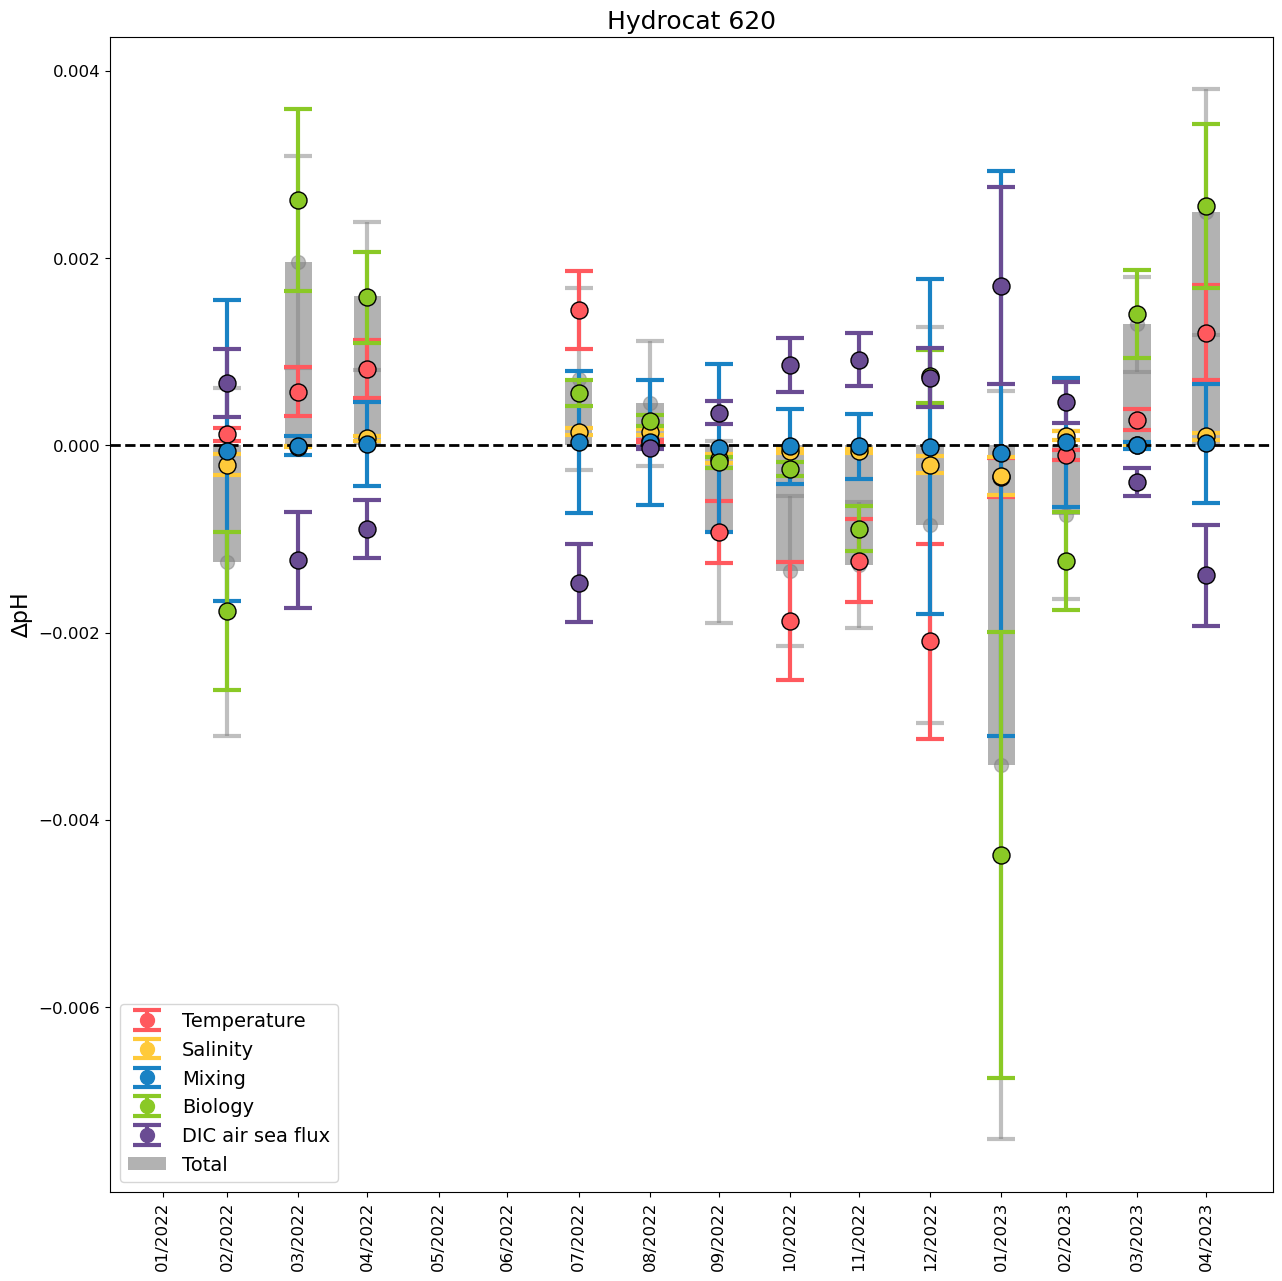

In [371]:
fig, ax = plt.subplots(figsize = [15,15])

df = comp620
dt = std620
title = 'Hydrocat 620'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



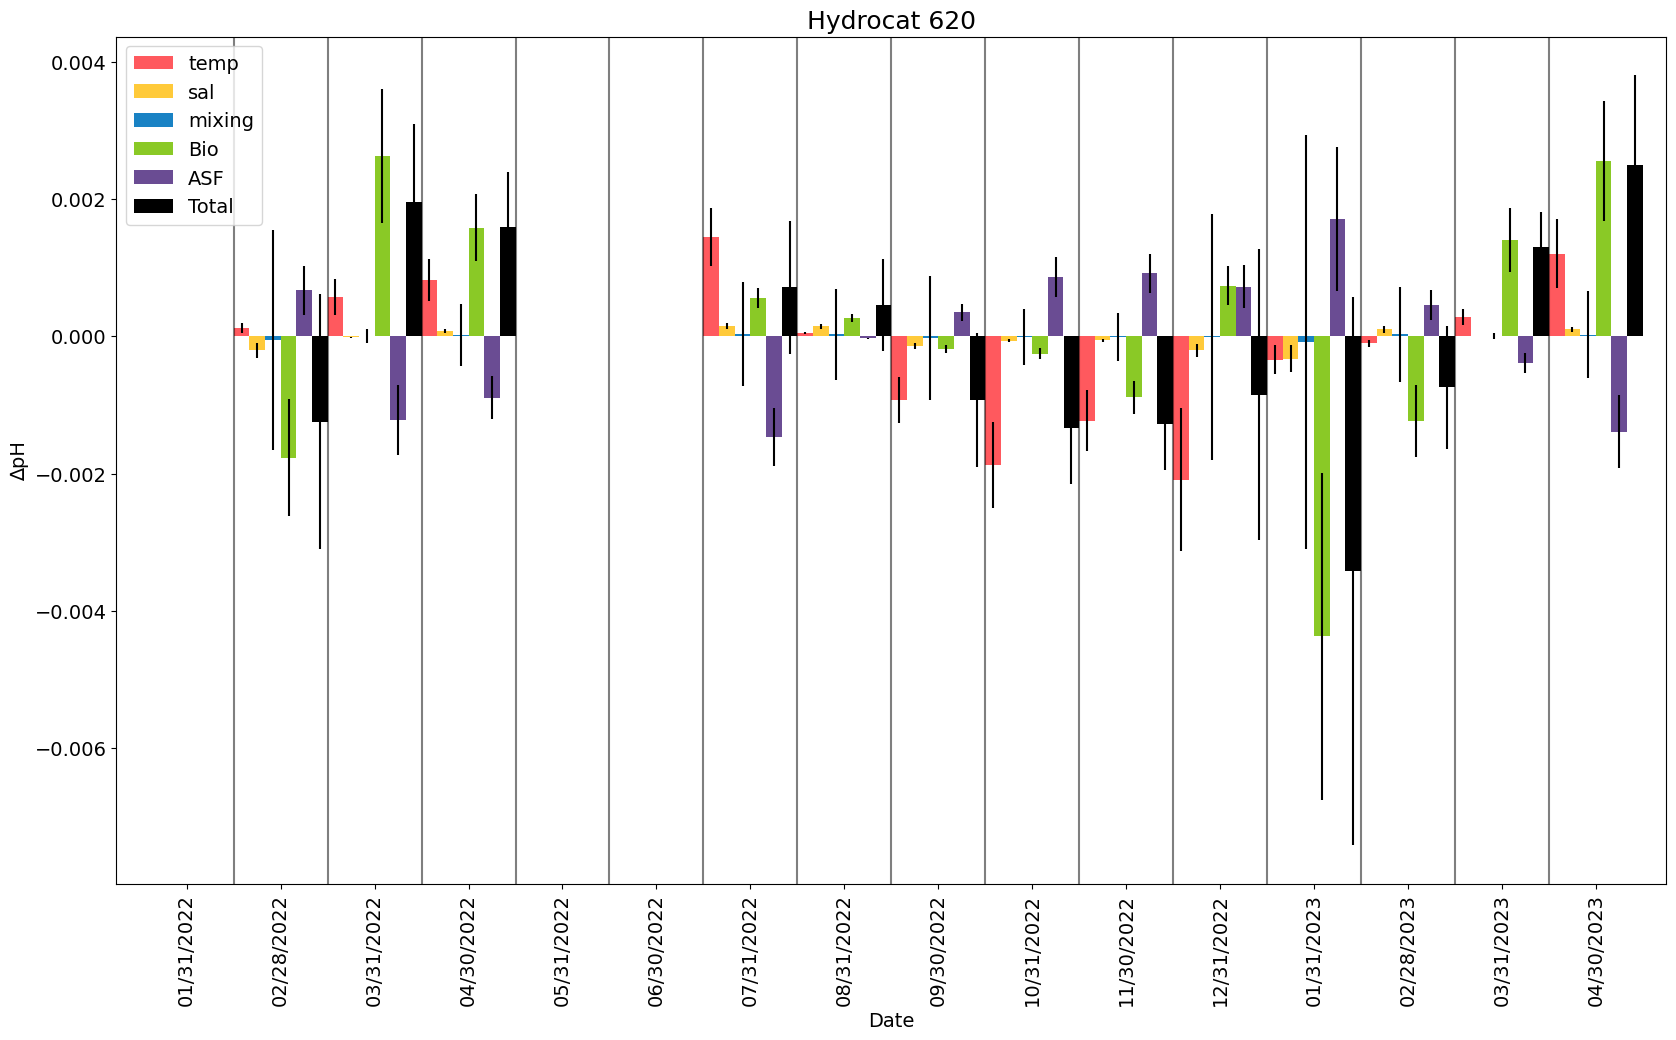

In [372]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [20,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('Hydrocat 620', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[4]+ran[5])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[5]+ran[6])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[6]+ran[7])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[7]+ran[8])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[8]+ran[9])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[9]+ran[10])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[10]+ran[11])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[11]+ran[12])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[12]+ran[13])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[13]+ran[14])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[14]+ran[15])/2, color = 'k', alpha = 0.5)


# Hydrocat 720

Text(0.5, 1.0, 'Hydrocat 720')

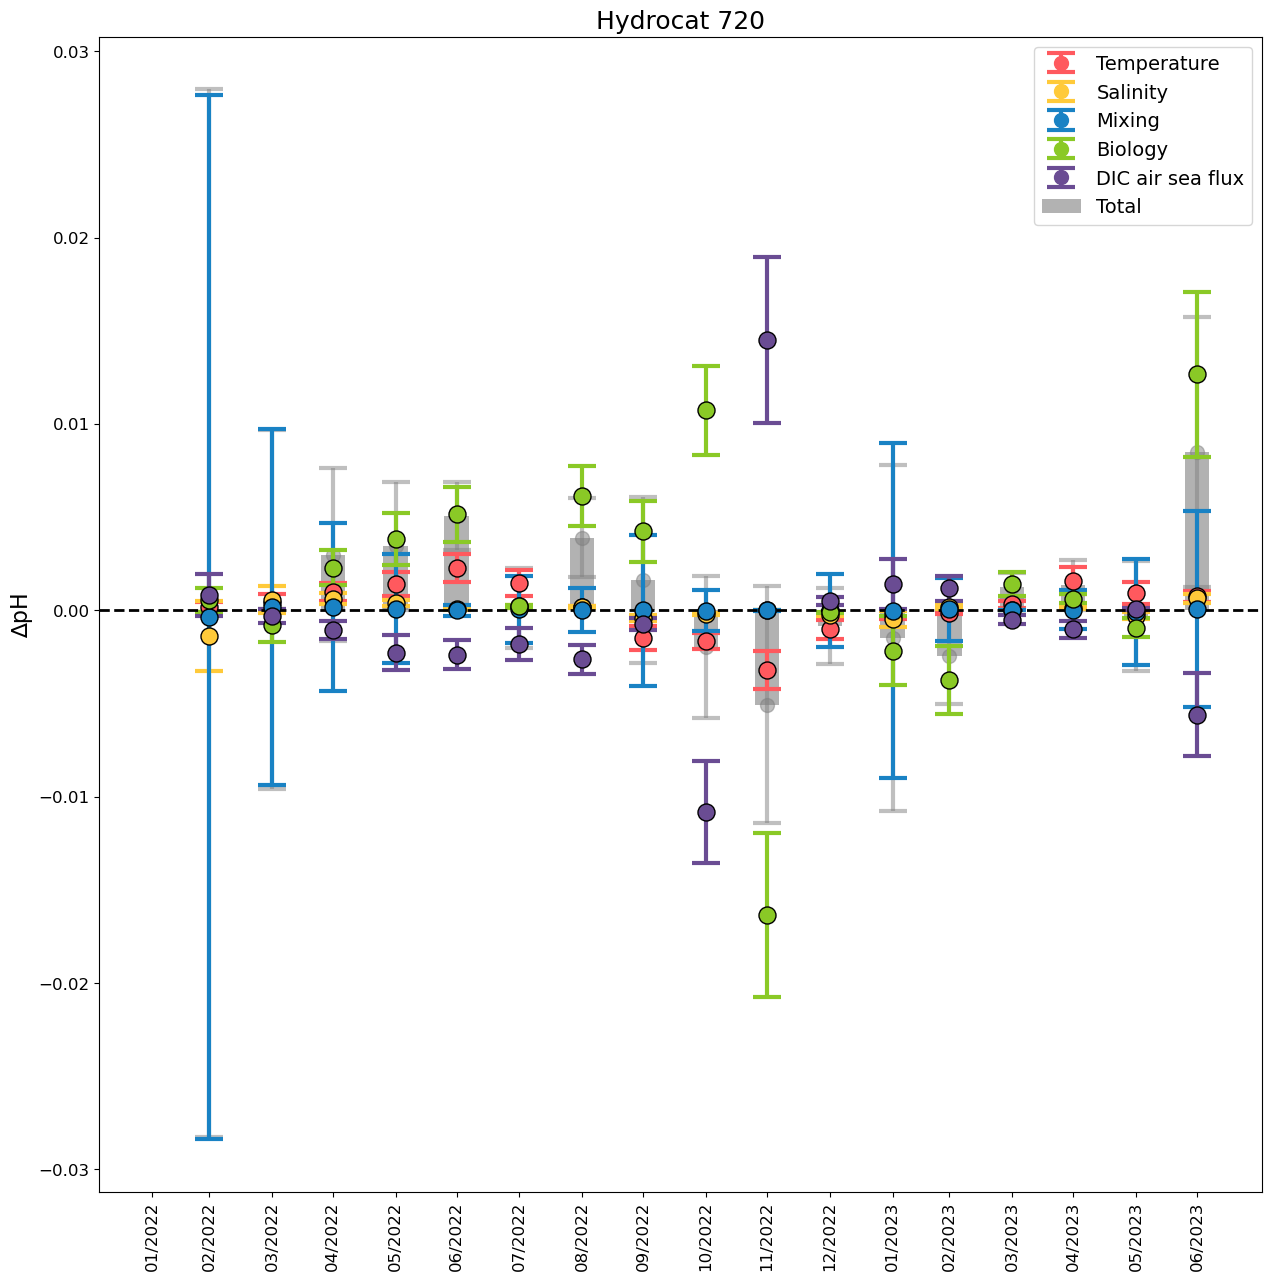

In [368]:
fig, ax = plt.subplots(figsize = [15,15])

df = comp720
dt = std720
title = 'Hydrocat 720'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



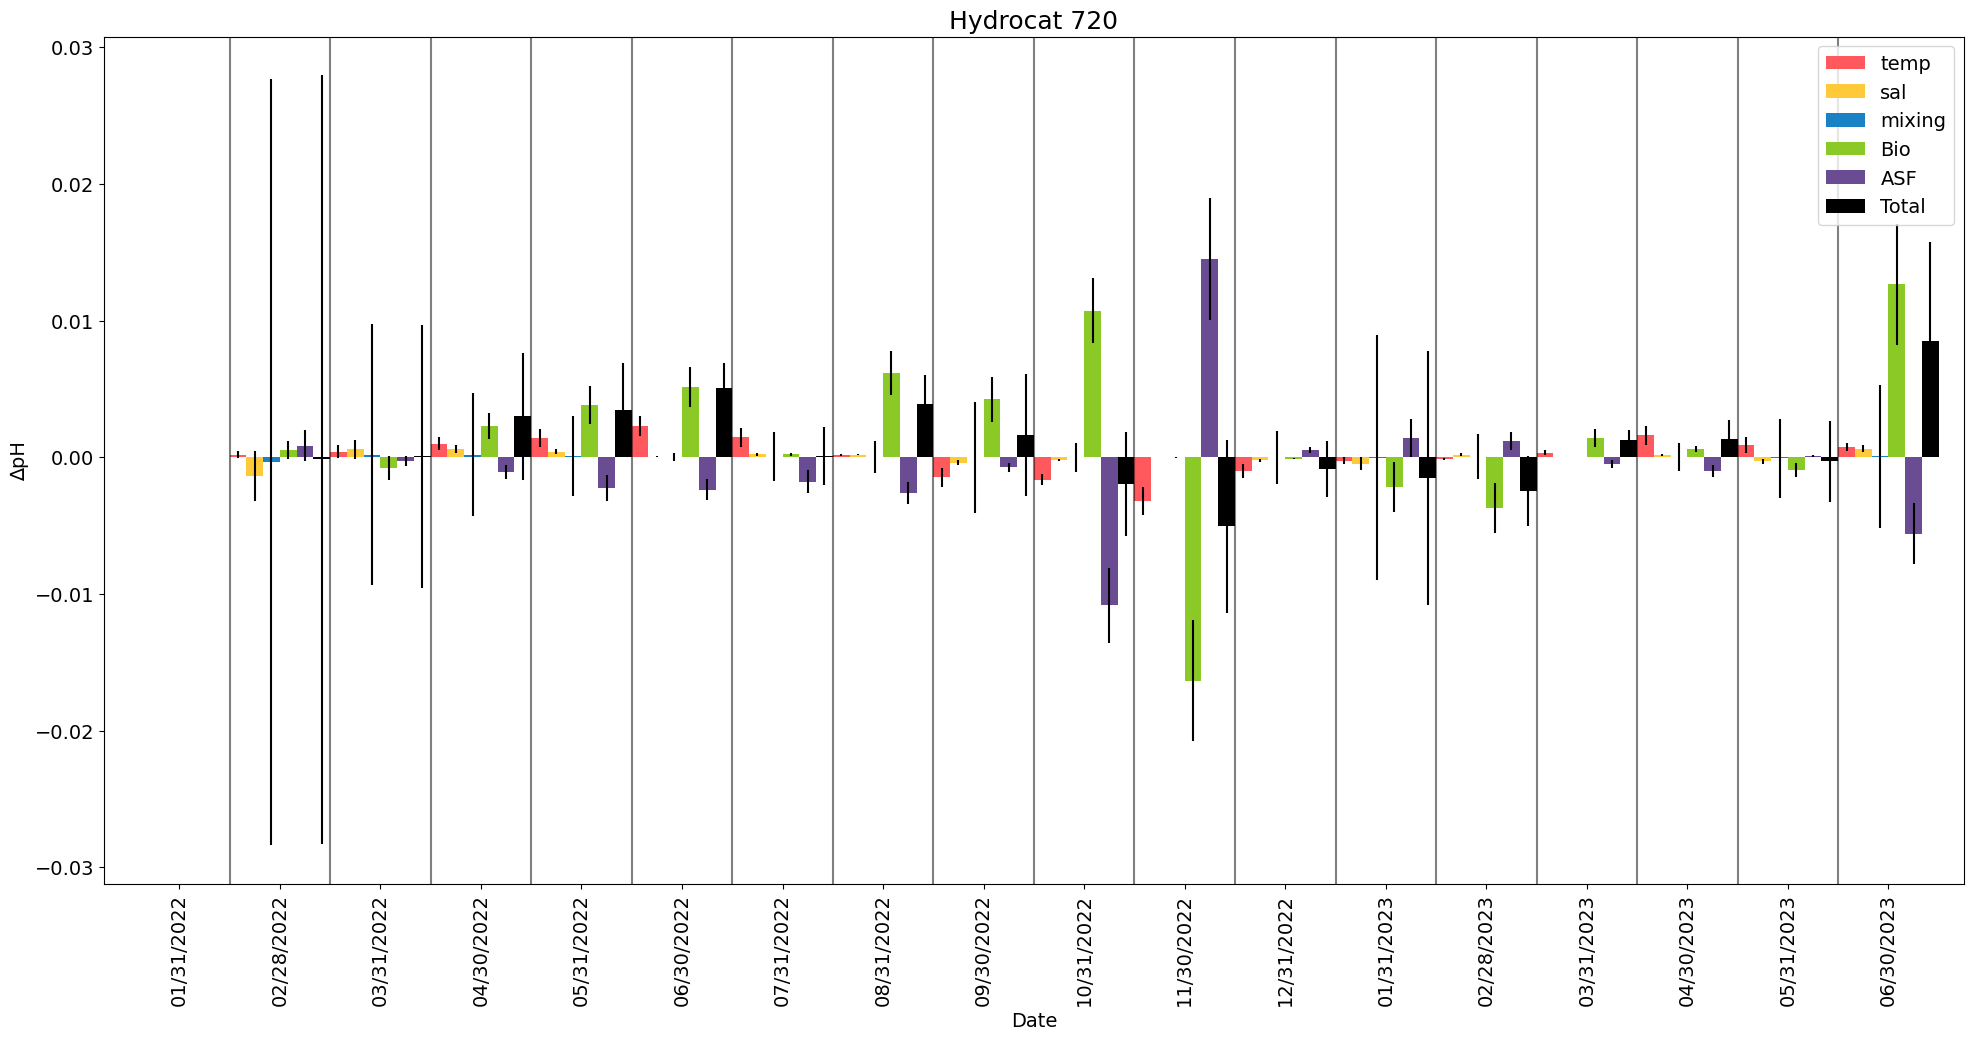

In [370]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [24,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('Hydrocat 720', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[4]+ran[5])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[5]+ran[6])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[6]+ran[7])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[7]+ran[8])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[8]+ran[9])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[9]+ran[10])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[10]+ran[11])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[11]+ran[12])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[12]+ran[13])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[13]+ran[14])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[14]+ran[15])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[15]+ran[16])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[16]+ran[17])/2, color = 'k', alpha = 0.5)



# MV

Text(0.5, 1.0, 'MV')

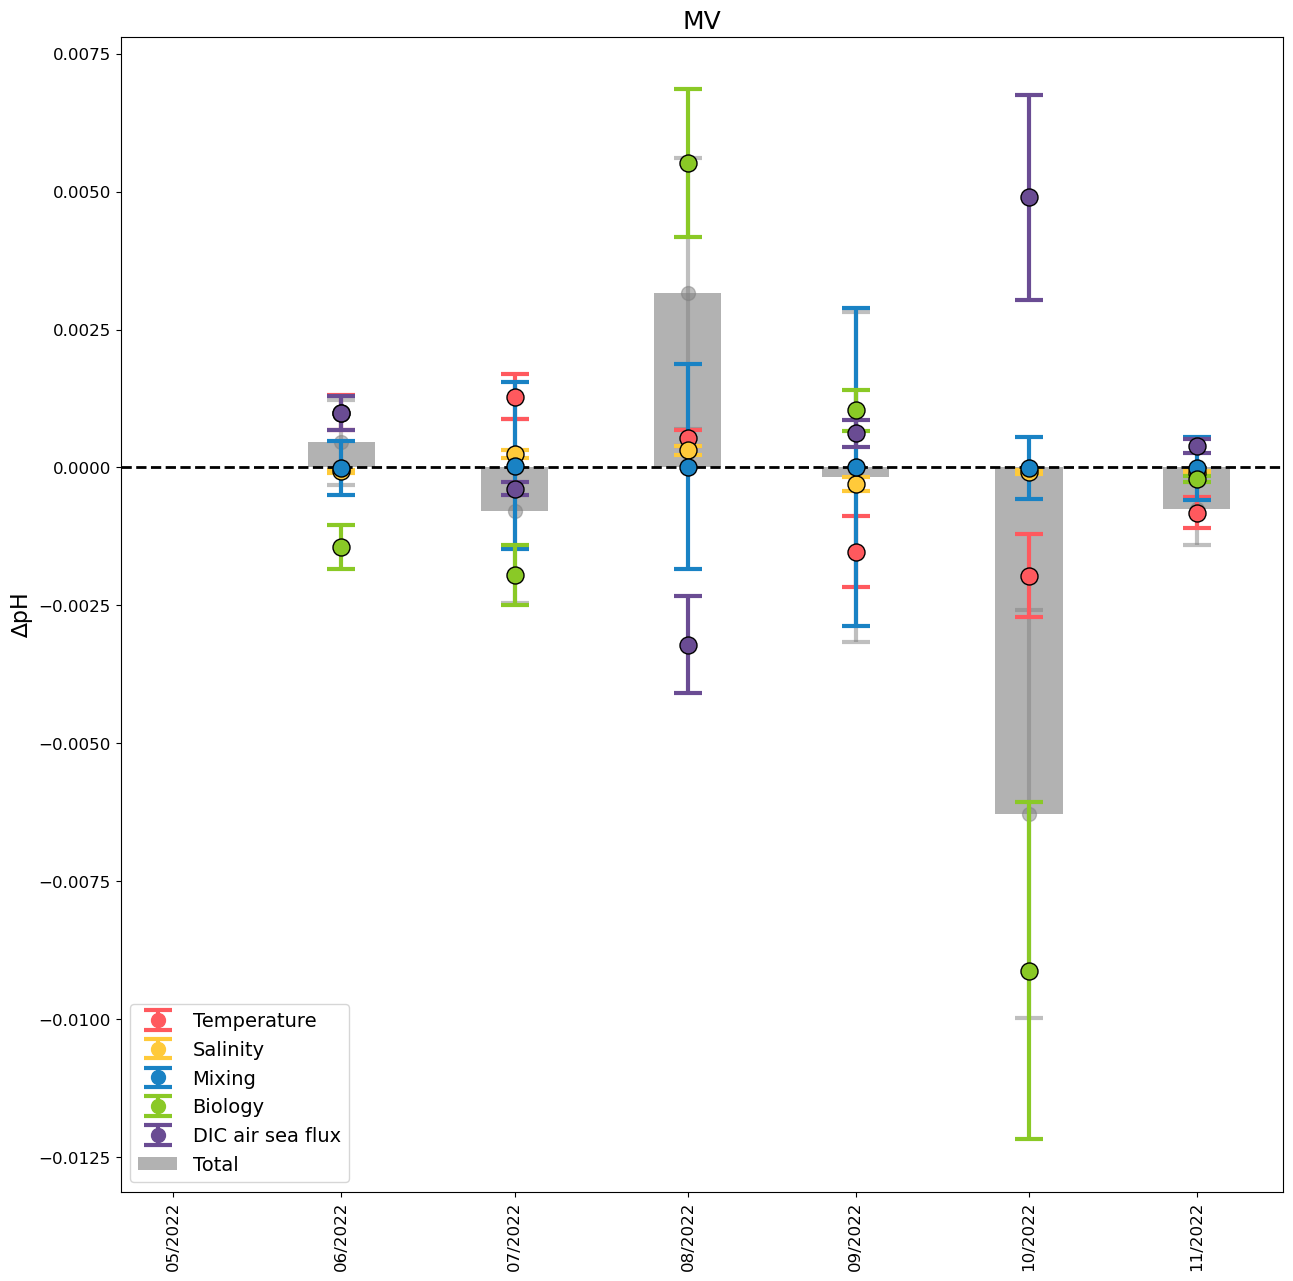

In [361]:
fig, ax = plt.subplots(figsize = [15,15])

df = compMV
dt = stdMV
title = 'MV'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



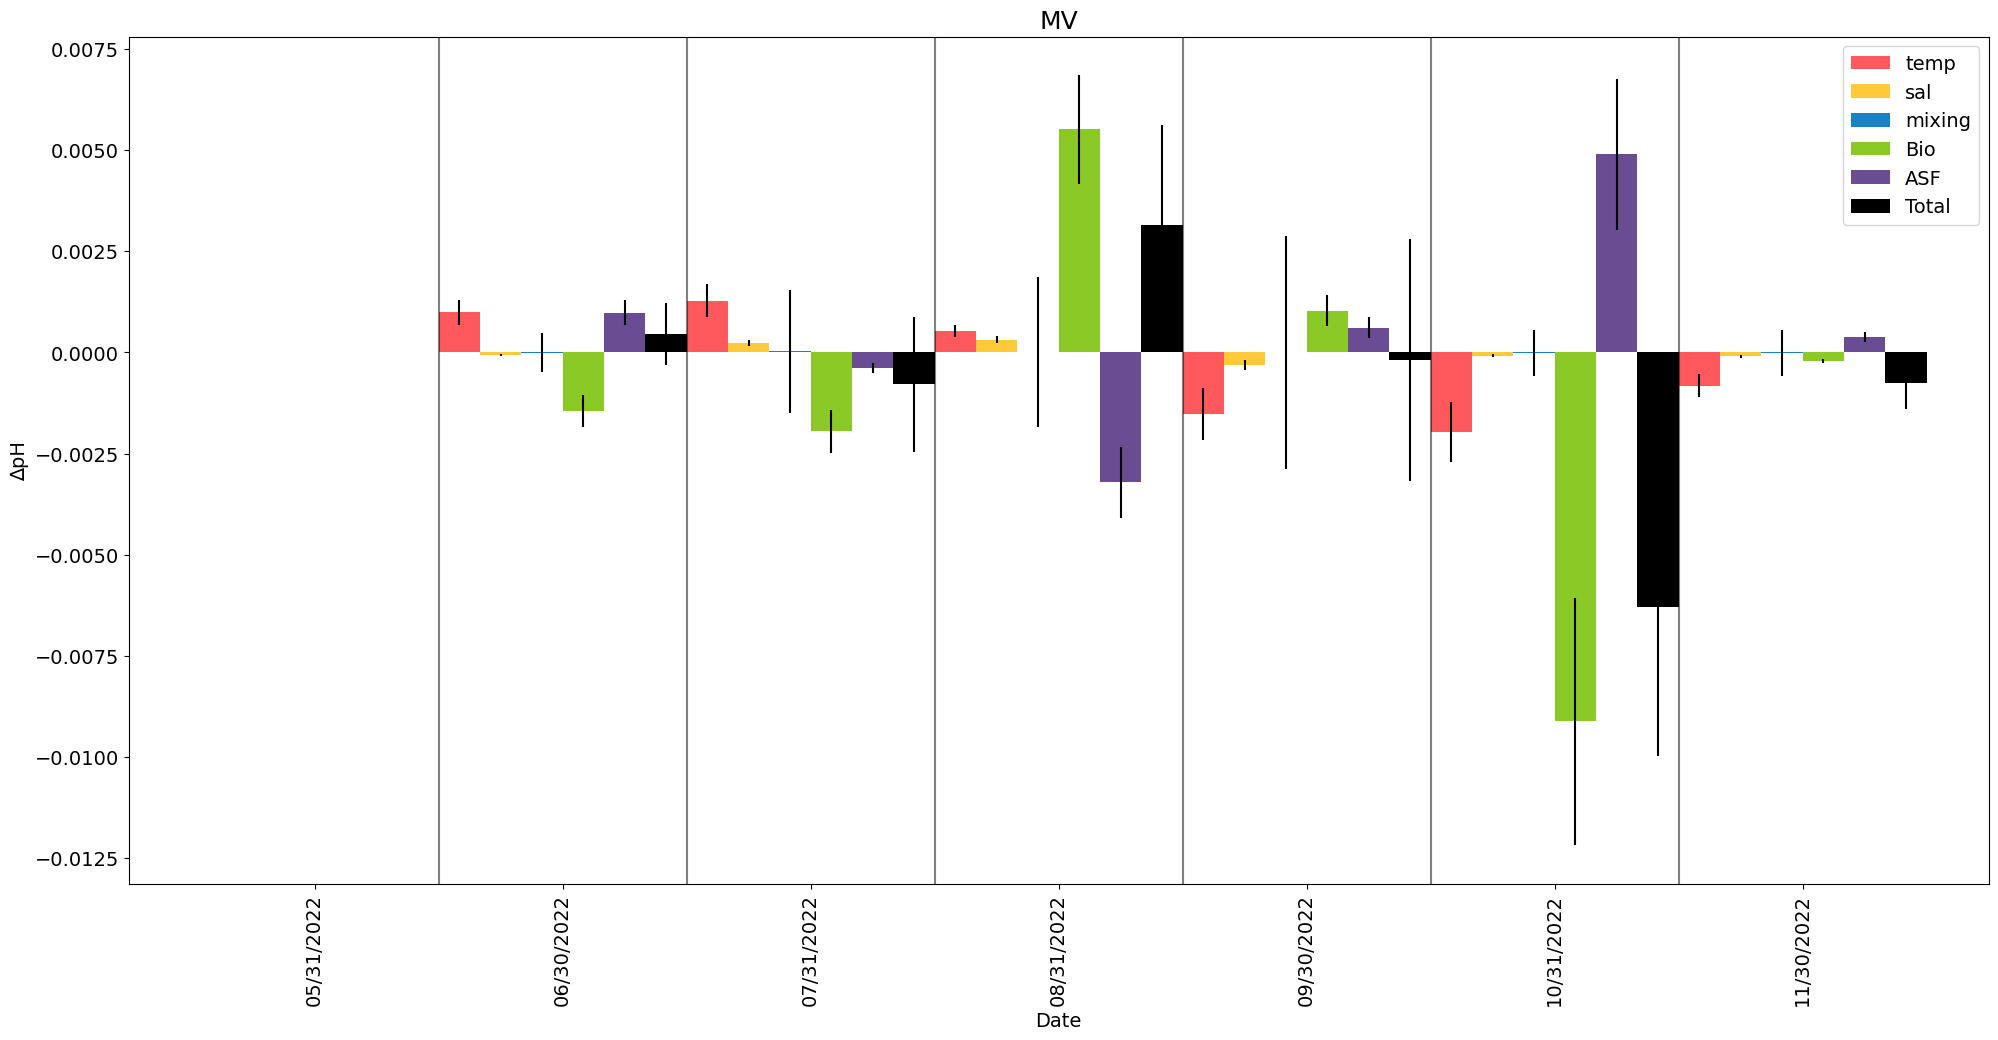

In [365]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [24,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('MV', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[4]+ran[5])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[5]+ran[6])/2, color = 'k', alpha = 0.5)



In [367]:
mix

DateTime
2022-05-31         NaN
2022-06-30   -0.000001
2022-07-31    0.000028
2022-08-31    0.000016
2022-09-30    0.000003
2022-10-31   -0.000014
2022-11-30   -0.000016
Freq: M, Name: Total mixing, dtype: float64

# QP

Text(0.5, 1.0, 'QP')

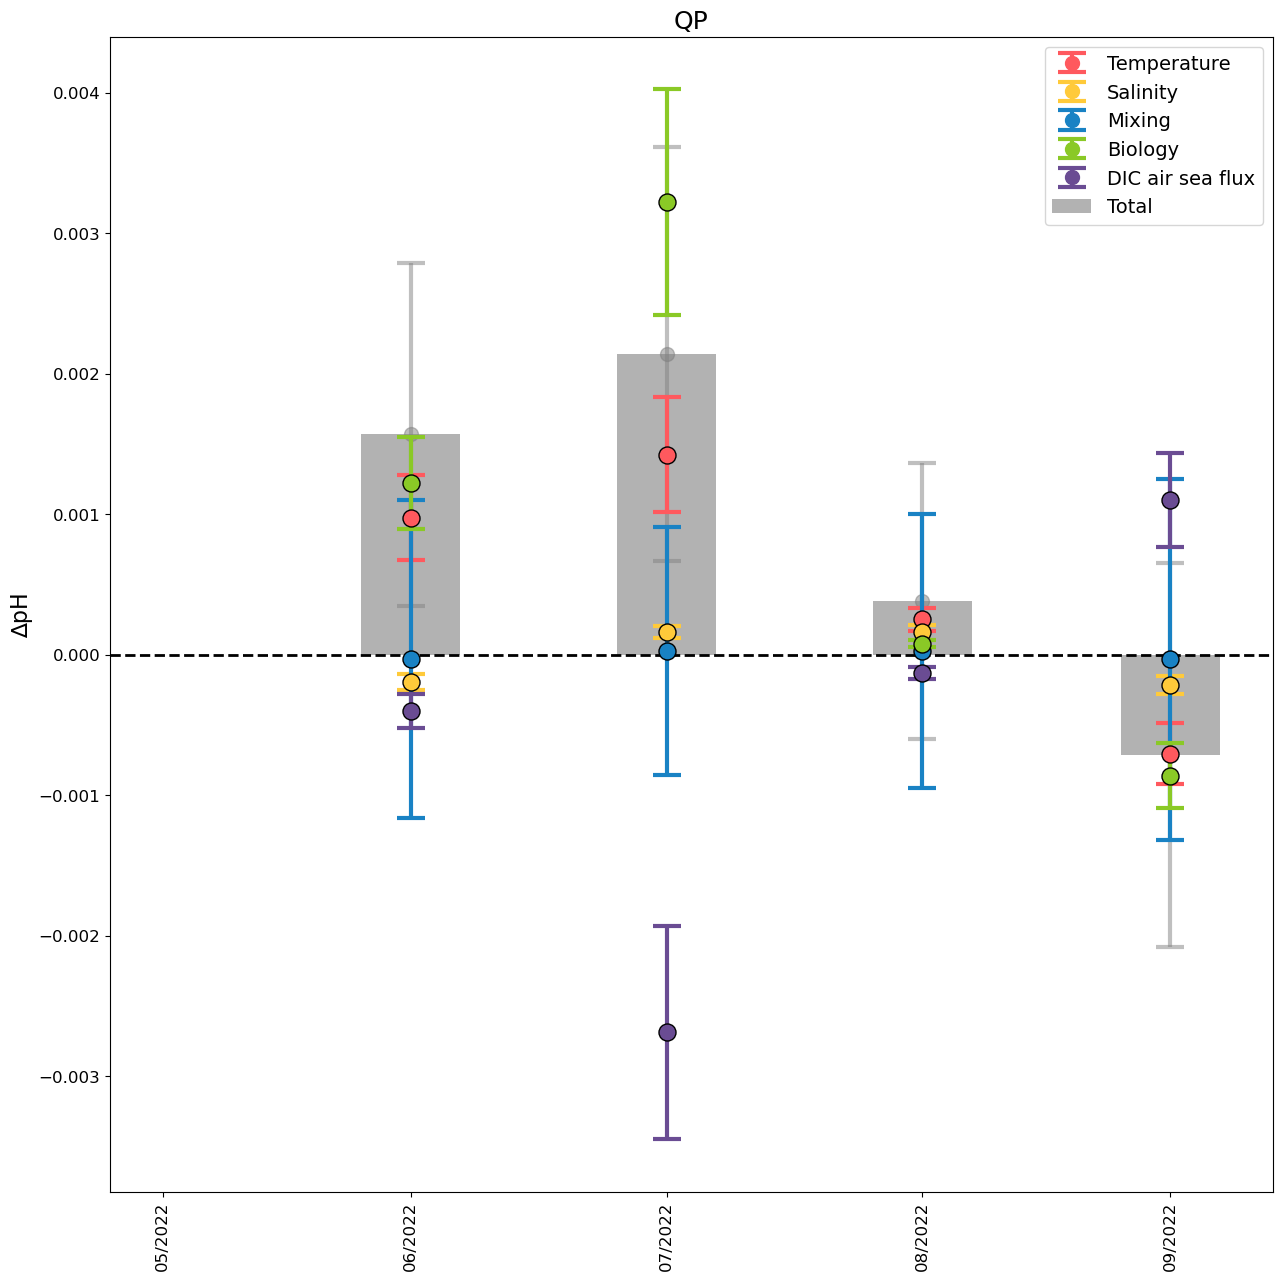

In [357]:
fig, ax = plt.subplots(figsize = [15,15])

df = compQP
dt = stdQP
title = 'QP'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



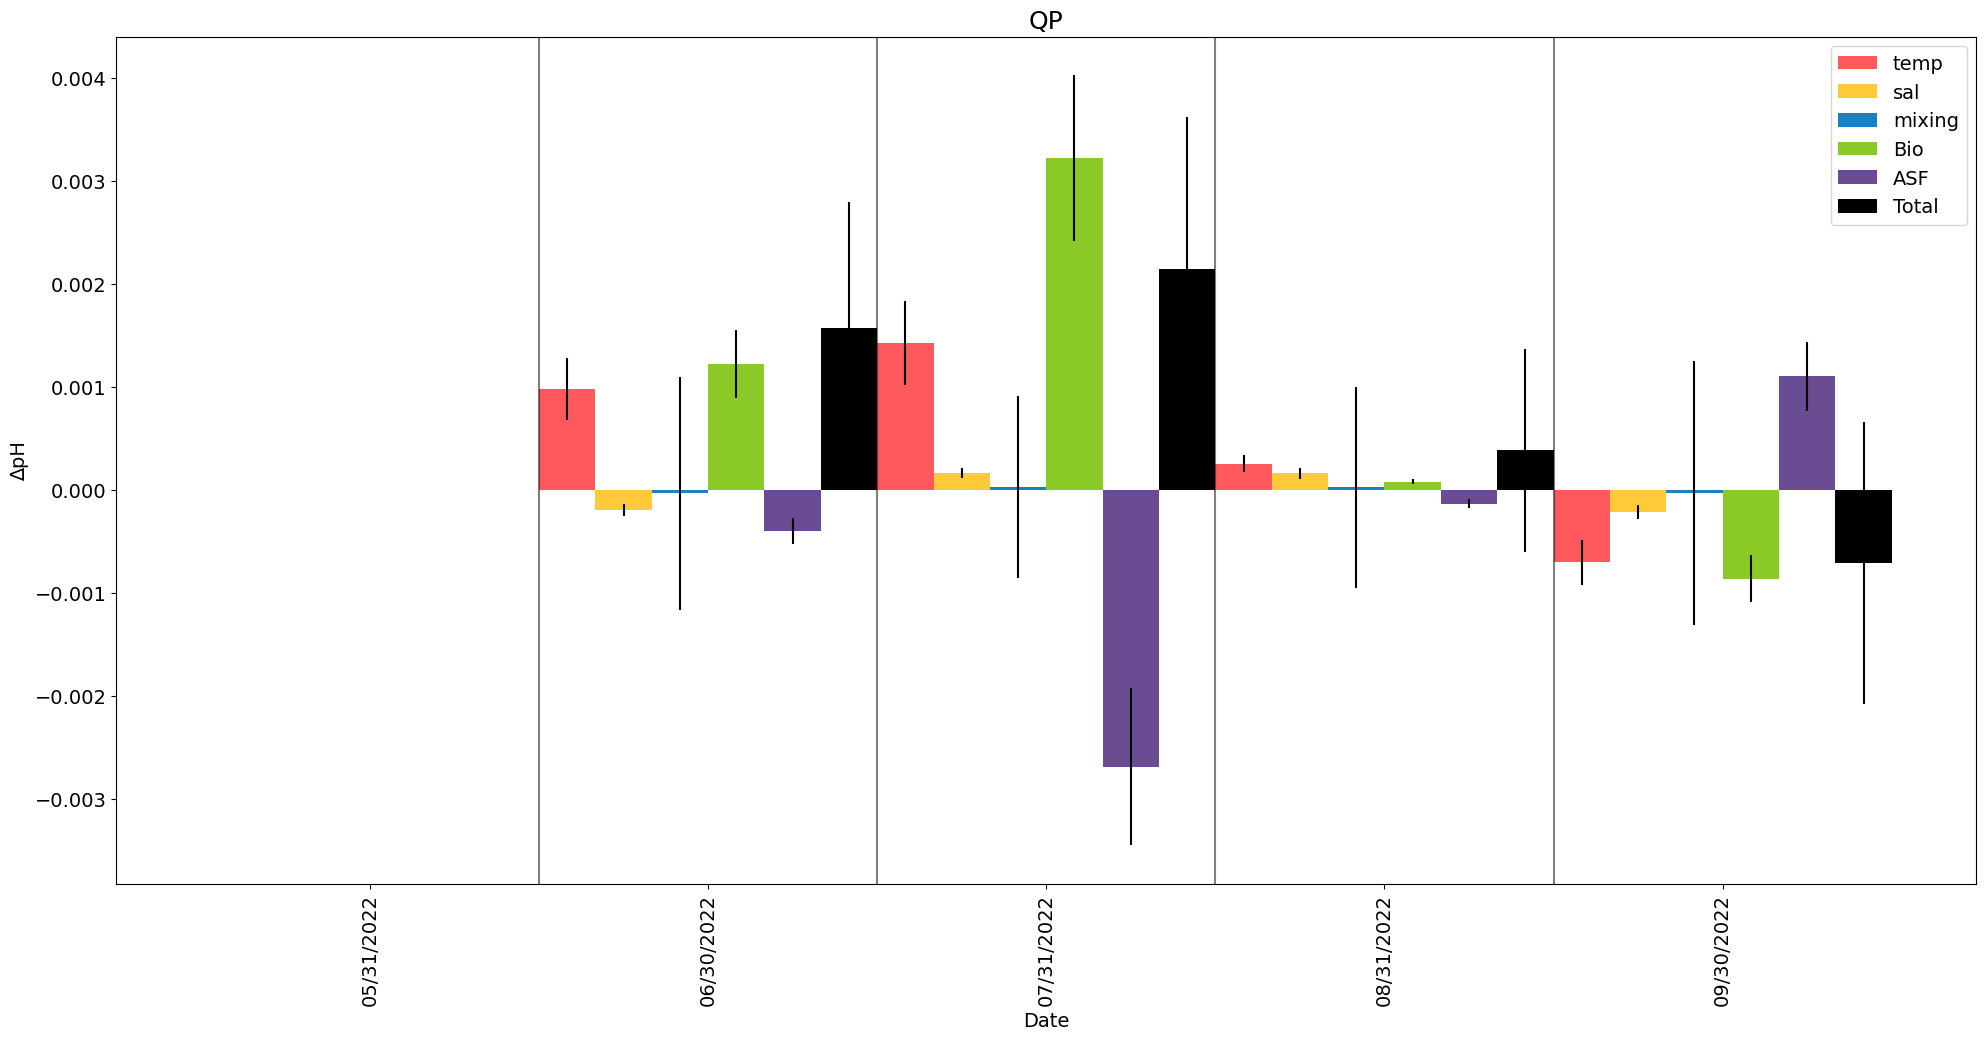

In [360]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [24,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('QP', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)



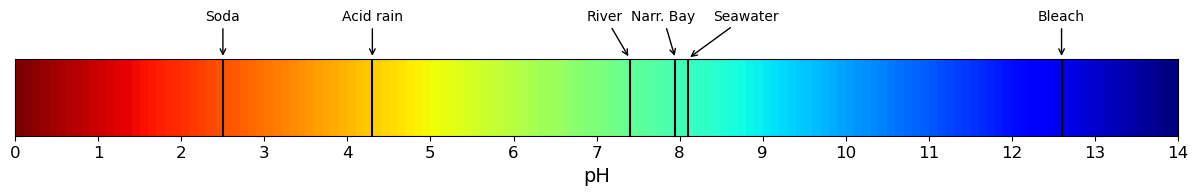

In [323]:
fig, ax = plt.subplots(figsize = [15,1])

# Z = np.arange(1,14.1,0.1)
# x = np.arange(1,14.1,0.1)
# y = np.arange(1,1.1,0.1)

np.random.seed(19680801)
Z = np.random.rand(14,14)
x = np.arange(0, 14.1, 0.1)  # len = 11
y = np.arange(0, 14.1,0.1)  # len = 7
C = np.mgrid[1:15:0.1, 1:15:0.1]
Z = C[0,:,:].transpose()
ax.pcolormesh(y,x,Z, cmap = 'jet_r')
ax.set_yticks([])
ax.tick_params('x',labelsize = 12)
ax.axvline(x = 7.95, color = 'k')
# ax.text(7.95, 15, 'Narragansett \nBay', horizontalalignment="center",
#        fontsize = 12)
plt.annotate('Narr. Bay',xy=(7.95, 14),xytext=(7.8, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 8.1, color = 'k')
plt.annotate('Seawater',xy=(8.1, 14),xytext=(8.8, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 7.4, color = 'k')
plt.annotate('River',xy=(7.4, 14),xytext=(7.1, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 2.5, color = 'k')
plt.annotate('Soda',xy=(2.5, 14),xytext=(2.5, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 12.6, color = 'k')
plt.annotate('Bleach',xy=(12.6, 14),xytext=(12.6, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 4.3, color = 'k')
plt.annotate('Acid rain',xy=(4.3, 14),xytext=(4.3, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
# ax.text(8.1, 15, 'Ocean \nAvg', horizontalalignment="center",
#        fontsize = 12)

ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]);
# ax.set_xticklabels([10**0,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10,10**-11,10**-12,10**-13,10**-14]);
# ax.set_xlabel('[H+] (mol/L)', fontsize = 12)
ax.set_xlabel('pH', fontsize = 14)
fig.savefig('/Users/akbaskind/Desktop/pHscale.png', bbox_inches='tight', transparent = True)